In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
import sys

!pwd

if tf.test.is_gpu_available(True):
    data_format='channels_first'
else: # running on cpu requires channels_last data format
    data_format='channels_last'

#print(data_format)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or 

/workspace/demon-sfm


In [2]:
base_path = '/workspace/demon-sfm'
examples_dir = os.path.join(base_path,'examples')
weights_dir = os.path.join(base_path,'weights')
python_path = os.path.join(base_path, 'python')
#print(python_path)

sys.path.insert(0, os.path.join(base_path, 'python'))
from depthmotionnet.networks_original import *

Using /workspace/demon-sfm/lmbspecialops/build/lib/lmbspecialops.so


In [3]:
# sample read data
img1 = Image.open(os.path.join(examples_dir,'sculpture1.png'))
img2 = Image.open(os.path.join(examples_dir,'sculpture2.png'))

# 경기전 read data
examples_dir = '/data/test-input/pose-good-res/01'
img1 = Image.open(os.path.join(examples_dir,'DJI_0003.resized.JPG'))
img2 = Image.open(os.path.join(examples_dir,'DJI_0004.resized.JPG'))

In [4]:
def prepare_input_data(img1, img2, data_format):
    """Creates the arrays used as input from the two images."""
    # scale images if necessary
    if img1.size[0] != 256 or img1.size[1] != 192:
        img1 = img1.resize((256,192))
    if img2.size[0] != 256 or img2.size[1] != 192:
        img2 = img2.resize((256,192))
    img2_2 = img2.resize((64,48))
        
    # transform range from [0,255] to [-0.5,0.5]
    img1_arr = np.array(img1).astype(np.float32)/255 -0.5
    img2_arr = np.array(img2).astype(np.float32)/255 -0.5
    img2_2_arr = np.array(img2_2).astype(np.float32)/255 -0.5
    
    if data_format == 'channels_first':
        img1_arr = img1_arr.transpose([2,0,1])
        img2_arr = img2_arr.transpose([2,0,1])
        img2_2_arr = img2_2_arr.transpose([2,0,1])
        image_pair = np.concatenate((img1_arr,img2_arr), axis=0)
    else:
        image_pair = np.concatenate((img1_arr,img2_arr),axis=-1)
    
    result = {
        'image_pair': image_pair[np.newaxis,:],
        'image1': img1_arr[np.newaxis,:], # first image
        'image2_2': img2_2_arr[np.newaxis,:], # second image with (w=64,h=48)
    }
    return result

input_data = prepare_input_data(img1,img2,data_format)

In [5]:
# init networks
gpu_options = tf.GPUOptions()
gpu_options.per_process_gpu_memory_fraction=0.8
session = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options))

bootstrap_net = BootstrapNet(session, data_format)
iterative_net = IterativeNet(session, data_format)
refine_net = RefinementNet(session, data_format)

session.run(tf.global_variables_initializer())

# load weights
saver = tf.train.Saver()
saver.restore(session,os.path.join(weights_dir,'demon_original'))


# run the network
result = bootstrap_net.eval(input_data['image_pair'], input_data['image2_2'])
for i in range(3):
    result = iterative_net.eval(
        input_data['image_pair'], 
        input_data['image2_2'], 
        result['predict_depth2'], 
        result['predict_normal2'], 
        result['predict_rotation'], 
        result['predict_translation']
    )
rotation = result['predict_rotation']
translation = result['predict_translation']
result = refine_net.eval(input_data['image1'],result['predict_depth2'])

INFO:tensorflow:Restoring parameters from /workspace/demon-sfm/weights/demon_original


### 결과

[[0.03994165 0.01108856 0.0043385 ]]
[[-0.17896575  0.9707835  -0.04161173]]


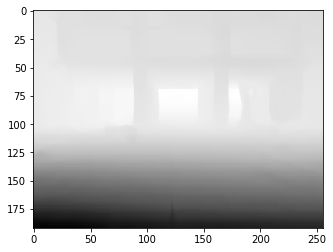

In [6]:
# pose result
print(rotation)
print(translation)

# depth result
plt.imshow(result['predict_depth0'].squeeze(), cmap='Greys')
plt.show()